In [ ]:
from statsmodels.stats.diagnostic import lilliefors # Kolmogorov-Smirnov
from statsmodels.stats.weightstats import ztest
import statsmodels.stats as sts # probplot
import scipy.stats as scs # T-test, Shapiro, Anderson, Wilcoxon, Mann-Whitney
import matplotlib.pyplot as plt

# Basics
import pandas as pd
import numpy as np

#seaborn
import seaborn as sns

In [ ]:
df = sns.load_dataset('iris')
df.head(2)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


In [ ]:
df.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

**Problem:** We want to compare if the petal length's means among the flowers are different

In [ ]:
# Separate both samples
setosa = df.query('species == "setosa"')['petal_length']
versicolor = df.query('species == "versicolor"')['petal_length']
virginica = df.query('species == "virginica"')['petal_length']

In [ ]:
versicolor.shape

(50,)

In [ ]:
# Check normality (p > 0.05 means normal distribution)
print('Setosa:', scs.shapiro(setosa))
print('versicolor:', scs.shapiro(versicolor))
print('virginica:', scs.shapiro(virginica))

Setosa: (0.9549766182899475, 0.05481043830513954)
versicolor: (0.9660047888755798, 0.1584833413362503)
virginica: (0.9621862769126892, 0.10977369546890259)


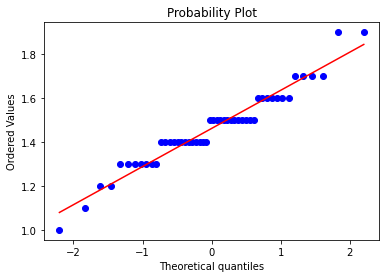

In [ ]:
stats.probplot(setosa, dist='norm', plot=plt)
plt.show()

In [ ]:
#Homegeneous Variance (Levene Test)
stat, p = stats.levene(setosa, virginica, center='mean')
print(f'Test Stat: {stat}')
print(f'p-Value: {p}')

Test Stat: 39.80074195637142
p-Value: 8.157096871531273e-09


The variance in this case is not homogeneous. 

In [ ]:
#Homegeneous Variance (Levene Test)
stat, p = stats.levene(setosa, versicolor, center='mean')
print(f'Test Stat: {stat}')
print(f'p-Value: {p}')

Test Stat: 35.4197094799367
p-Value: 4.132475340907607e-08


In [ ]:
#Homegeneous Variance (Levene Test)
stat, p = stats.levene(virginica, versicolor, center='mean')
print(f'Test Stat: {stat}')
print(f'p-Value: {p}')

Test Stat: 1.0204615845018339
p-Value: 0.31489722188956176


## Z Test

We must set our Hypothesis test parameters.
* Ho = No difference between means : p > 0.05
* Ha = There is difference between means : p < 0.05

In [ ]:
# T-Test for two independent Samples
ztest(setosa, virginica)

NameError: ignored

p-Values is 0, so there we can reject the Null Hypothesis. There is statistically significant difference between the means of *setosa* and *virginica* flowes

In [ ]:
# T-Test for two independent Samples
ztest(setosa, versicolor)

p-Values is 0, so there we can reject the Null Hypothesis. There is statistically significant difference between the means of setosa and virginica flowes

In [ ]:
# T-Test for two independent Samples
ztest(virginica, versicolor)

p-Values is 0, so there we can reject the Null Hypothesis. There is statistically significant difference between the means of setosa and virginica flowes

In [ ]:
print('setosa', setosa.describe() )
print('virginica', virginica.describe() )
print('versicolor', versicolor.describe() )

In [ ]:
def normality_tests(my_sample):
  # Shapiro Test
  _, p1 = scs.shapiro(my_sample)
  print('Shapiro:')
  print('Not normal | p-value:' if p1 < 0.05 else 'Normal | p-value:', p1)
  print('-------------------------------')

# Kolmogorov test
  _, p2 = lilliefors(my_sample, dist='norm')
  print('Kolmogorov:')
  print('Not normal | p-value:' if p2 < 0.05 else 'Normal | p-value:', p2)
  print('-------------------------------')

  # Anderson
  stat, p3, _ = scs.anderson(my_sample, dist='norm')
  print('Anderson:')
  print('Not normal | p-value:' if stat > p3[2] else 'Normal | stat:', stat, ':: p-value:', p3[2])

  # QQPlot
  scs.probplot(my_sample, dist='norm', plot=plt)
  plt.title('QQ Plot')
  plt.show()

## T-Test

1 sample compared to a number (population mean)
* Ho = mean is equal : p > 0.05
* Ha = mean is different : p < 0.05

In [ ]:
# T-Test one sample
scipy.stats.ttest_1samp(df.mpg, popmean= 28)

Ttest_1sampResult(statistic=-11.448844667034251, pvalue=2.0243620914866503e-26)

p-Value is lower than alfa, so we can reject the Ho with 95% confidence.

## A/B Testing

**Power Function**: The power of a hypothesis test is the probability of making the correct decision if the alternative hypothesis is true. In general, for every hypothesis test we conduct, we will try to maximize the power. Typically, we desire the power to be 0.8 or greater.


In [ ]:
from scipy import stats
def get_power(n, p1, p2, cl):
  '''size(n), control group mean (p1), test_group mean (p2), and confidence interval (cl)
  Returns the prob to make the right decision in an AB test'''

  alpha = 1 - cl
  qu = stats.norm.ppf(1 - alpha/2)
  diff = abs(p2-p1)
  bp = (p1+p2) / 2
    
  v1 = p1 * (1-p1)
  v2 = p2 * (1-p2)
  bv = bp * (1-bp)
    
  power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
  power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
   
  power = power_part_one + power_part_two
   
  return (power)

In [ ]:
get_power(1000, 10, 12, 0.95) 

(-213.79663221513727-1.7763568394002505e-13j)

The sample size the function returns indicates that under the desired power, if analysts want to observe the change in the mean between test groups and control groups for certain confidence interval, the analyst will need N sample.

In [ ]:
def get_sample_size(power, p1, p2, cl, max_n=1000000):
  n = 1 
  while n <= max_n:
    tmp_power = get_power(n, p1, p2, cl)
    if tmp_power >= power: 
      return f'Given the power of {power} and C.I. of {cl}, the sample size needed is {n}' 
    else: 
      n = n + 100
  return "Increase Max N Value"

In [ ]:
# Trial1
conversion_rate = 0.03
power = 0.8
cl = 0.9
percent_lift = 0.1
conversion_rate_p2 = conversion_rate * (1 + percent_lift)

get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

42001

The p-value function here is to test the result value between test groups and control groups, given the sample size of each group, whether the change is significant enough to reach the A/B testing conclusion.

In [ ]:
def get_pvalue(con_conv, test_conv, con_size, test_size):
  lift = -abs(test_conv - con_conv)
   
  scale_one = con_conv * (1-con_conv) * (1/ con_size)
  scale_two = test_conv * (1-test_conv) * (1/ test_size)
  scale_val = (scale_one + scale_two) ** 0.5
   
  p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)  
  return p_value

In [ ]:
# Trial 1
con_conv = 0.034351
test_conv = 0.041984
con_size = 48236
test_size = 49867
get_pvalue(con_conv, test_conv, con_size, test_size)   
# 4.257297485586909e-10

4.257297485586909e-10

The last handy function for A/B testing setting is the confidence interval function. Confidence interval will grant the analyst a range of estimation, and it somehow reveals the snapshot of the population mean. 

In [ ]:
def get_ci(lift, alpha, sd):
  val = abs(stats.norm.ppf((1-alpha)/2))
    
  lwr_bnd = lift - val * sd
  upr_bnd = lift + val * sd
    
  return (lwr_bnd, upr_bnd)

In [ ]:
# Trial 1
test_conv = 0.102005
con_conv = 0.090965
test_size = 56350
con_size = 58583
lift_mean = test_conv - con_conv
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - con_conv) * con_conv / con_size
lift_sd = lift_variance**0.5
get_ci(lift_mean, 0.95, lift_sd)

(0.007624337671217316, 0.014455662328782672)

### Teste

#### Define Baseline and Lift

In [ ]:
# Define baseline conversion rate. We have 10% conversion and want to improve 2%
bcr = 0.10

# Desired uplift
d_hat = 0.02

#### Define Sample Size

In [ ]:
conversion_rate = 0.1
power = 0.8
cl = 0.9
percent_lift = 0.2
conversion_rate_p2 = conversion_rate * (1 + percent_lift)

get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

'Given the power of 0.8 and C.I. of 0.9, the sample size needed is 3101'

In [ ]:
# Define Control and Test Group Sizes
N_A = int(3100/2)
N_B = int(3100/2)

#### Run the Test

In [ ]:
import scipy.stats as scs
import pandas as pd
import numpy as np


def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [ ]:
ab_data = generate_data(N_A, N_B, bcr, d_hat)

In [ ]:
ab_data.head(3)

,group,converted
0,B,0
1,B,0
2,A,1


In [ ]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [ ]:
ab_summary

,converted,total,rate
group,,,
A,136,1512,0.089947
B,30,1588,0.018892


## Test Bus School

Going to the bus stop, the bus seems to always arrive at different times. But can we have an idea of when it will arrive? 
Confidence Interval in Python

In [ ]:
import pandas as pd
import numpy as np
from datetime import time

In [ ]:
times = [time(hour=4, minute=np.random.randint(20, 59)) for i in range(50)]
df = pd.DataFrame({'day':range(1,51), 'arrival':times})

In [ ]:
df.head(3)

,day,arrival
0,1,04:20:00
1,2,04:46:00
2,3,04:24:00


Let's say I was told the bus will arrive daily at 4:30. What's the confidence in that information 95%?

In [ ]:
# describe
df.arrival.describe()

count           50
unique          28
top       04:24:00
freq             5
Name: arrival, dtype: object

In [ ]:
# prepare data
df['minute'] = [df.arrival[i].minute for i, v in enumerate(df.arrival)]
df.head(4)

,day,arrival,minute
0,1,04:20:00,20
1,2,04:46:00,46
2,3,04:24:00,24
3,4,04:47:00,47


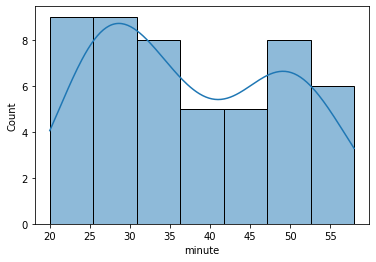

In [ ]:
sns.histplot(df.minute, kde=True);

In [ ]:
def conf_interval(conf_level, df):
  mu = df.mean()
  n = len(df)
  stdev - df.std()
  z_value = {0.90:1.645, 0.95:1.96, 0.99:2.575} 
  E = z_value[conf_level] * (stdev/np.sqrt(n))

  return f'The confidence interval for this distribution is {round(mu - E,1)} < {round(mu,1)} < {round(mu + E, 1)}'

In [ ]:
# Shapiro Normal Test
scs.shapiro(df.minute)

(0.9200297594070435, 0.002363754203543067)

Distribution is not normal. So let's bootstrap.

In [ ]:
import scipy.stats as scs
import numpy as np

def bootstrap_ci(df, samples, reps, conf_level):
  '''
  Function to calculate the confidence interval of a non-normal sample using bootstrap method.
  The function will take in a series or list, extract a random sample for n reps and calculate the mean of the sample.
  Then test normality and print the lower and upper boundaries of the confidence interval.
  Inputs:
  * df: Pandas Series with the data.
  * samples: [int] number of samples you want to extract from the series
  * reps: [int] repetitions of the bootstrap sampling
  * conf_level: [float] 0.90, 0.95 or 0.99.

  Example:
  bootstrap_ci(df, 30, 50, 0.95)
  '''
  # Bootstrap Samples
  bootstrap = [df.sample(samples, replace=True).mean() for i in range(reps)]
  
  # Normality Test
  stat, p = scs.shapiro(bootstrap)
  if p > 0.05:
    print(f'Normal distribution confirmed. p-Value: {p}')
  else:
    return f'Distribution is not normal. Function ended. p-Value: {p}'
  
  # Return values
  if conf_level == 0.90:
    return (round( np.percentile(bootstrap, 5), 2) , round( np.percentile(bootstrap, 95), 2) )
  elif conf_level == 0.95:
    return (round( np.percentile(bootstrap, 2.5), 2) , round( np.percentile(bootstrap, 97.5), 2) )
  else:
    return (round( np.percentile(bootstrap, 0.5), 2) , round( np.percentile(bootstrap, 99.5), 2) )

In [ ]:
bootstrap_ci(df.minute, samples=30, reps=50, conf_level=0.99)

Normal distribution confirmed. p-Value: 0.6444646120071411


(33.41, 41.07)

In [ ]:
min_bootstrap = [df.minute.sample(30, replace=True).mean() for i in range(50)]

In [ ]:
df['bootstrap'] = min_bootstrap

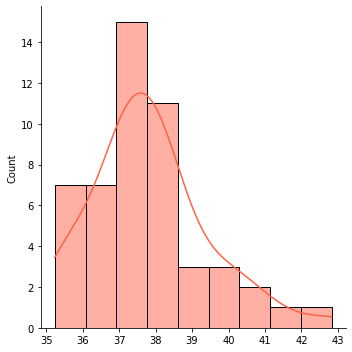

In [ ]:
sns.displot(min_bootstrap, kde=True, color='tomato');

In [ ]:
print( f' Lower boundary: {np.percentile(min_bootstrap, 2.5)} | Upper boundary: {np.percentile(min_bootstrap, 97.5)} ')

 Lower boundary: 35.30416666666667 | Upper boundary: 41.22749999999999 


In [ ]:
# Now it is normal
scs.shapiro(min_bootstrap)

(0.9797706604003906, 0.5423312187194824)

In [ ]:
# Confidence Interval
conf_interval(0.95, df.bootstrap)

'The confidence interval for this distribution is 41.0 < 41.8 < 42.5'

In [ ]:
scs.norm.interval(alpha=0.95, loc=df.minute.mean(), scale=scs.sem(df.minute))

(37.677084442794566, 43.92291555720543)

# Mann-Whitney

In [ ]:
# imports
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
import scipy.stats as scs
import statsmodels.stats as sts
from statsmodels.stats.diagnostic import lilliefors # Kolmogorov-Smirnov

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load a dataframe
df = sns.load_dataset('tips')

In [ ]:
df.head(2)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3


We want to know if the differences between the tips given by smokers is different than those given by non-smokers.

We're comparing medians, now, as the test is non-parametric.

In [ ]:
# Let's separate the  data
non_smoker = df.query(' smoker == "No" ')['tip']
smoker = men = df.query(' smoker == "Yes" ')['tip']

In [ ]:
def normality_tests(my_sample):
  # Shapiro Test
  _, p1 = scs.shapiro(my_sample)
  print('Shapiro:')
  print('Not normal | p-value:' if p1 < 0.05 else 'Normal | p-value:', p1)
  print('-------------------------------')

# Kolmogorov test
  _, p2 = lilliefors(my_sample, dist='norm')
  print('Kolmogorov:')
  print('Not normal | p-value:' if p2 < 0.05 else 'Normal | p-value:', p2)
  print('-------------------------------')

  # QQPlot
  scs.probplot(my_sample, dist='norm', plot=plt)
  plt.title('QQ Plot')
  plt.show()

Shapiro:
Not normal | p-value: 2.058691705997262e-08
-------------------------------
Kolmogorov:
Not normal | p-value: 0.00017508524610536795
-------------------------------


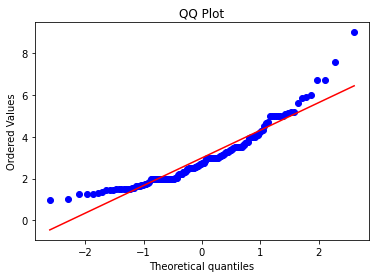

In [ ]:
# Test Normality
# p > 0.05 is normal.
# p < 0.05 is not normal
normality_tests(non_smoker)

Shapiro:
Not normal | p-value: 3.6124649227531336e-07
-------------------------------
Kolmogorov:
Not normal | p-value: 0.00558297839995531
-------------------------------


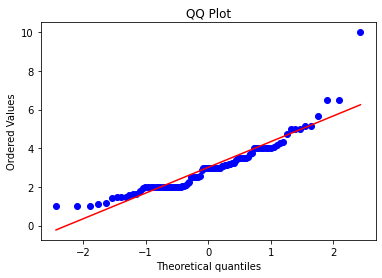

In [ ]:
# Test Normality
# p > 0.05 is normal.
# p < 0.05 is not normal
normality_tests(smoker)

Considering that both distributions are not normally distributed, we're going to perform a non-parametric test, centered in the median.

* Ho = There is no difference between medians for tips of smokers and non-smokers | **p-Value > 0.05**
* Ha = There is difference between medians for tips of smokers and non-smokers | **p-Value < 0.05**

In [ ]:
# Significance threshold
alfa = 0.05

# Statistical Test
stat, p = scs.mannwhitneyu(smoker, non_smoker)
print(f'Test Statistic: {stat}')

if p > alfa:
  print(f'p-Value: {round(p,3)} is higher than {alfa}, thus there is no difference between the medians.')
else:
  print(f'p-Value: {round(p,3)} is lower than {alfa}, thus the difference between the medians is statistically significant.')

Test Statistic: 6880.0
p-Value: 0.396 is higher than 0.05, thus there is no difference between the medians.


In [ ]:
smoker.median()

3.0

In [ ]:
non_smoker.median()

2.74

# Z-Test One Sample

In [ ]:
from scipy import stats #Shapiro
from statsmodels.stats.diagnostic import lilliefors # Kolmogorov-Smirnov
from statsmodels.stats.weightstats import ztest

import statsmodels.stats as sts # probplot
import matplotlib.pyplot as plt

import pandas as pd

#seaborn
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = sns.load_dataset('tips')

In [ ]:
df.tip.mean()

2.9982786885245902

Shapiro:
Not normal | p-value: 0.005448382347822189
-------------------------------
Kolmogorov:
Normal | p-value: 0.05278659510924541
-------------------------------
Anderson:
Not normal | p-value: 0.755


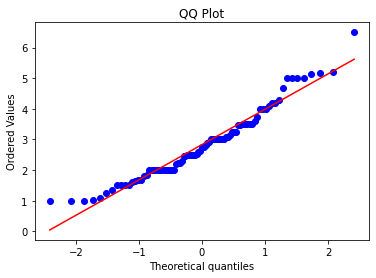

In [ ]:
my_sample = df.tip[df.sex=='Female']
normality_tests(my_sample)

In [ ]:
ztest(my_sample, value=2.99827)

(-1.3258835563461384, 0.18487827048905192)

# T Test for One Sample

In [ ]:
#from scipy import stats #Shapiro
import scipy.stats as scs # t-test
from statsmodels.stats.diagnostic import lilliefors # Kolmogorov-Smirnov

import statsmodels.stats as sts # probplot
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


In [ ]:
df = pd.DataFrame({'my_sampleA':np.random.normal(98, size=100),
                   'my_sampleB': np.random.normal(7500, size=100)})
df.head(2)

,my_sampleA,my_sampleB
0,98.733554,7500.554617
1,97.657984,7499.840939


Shapiro:
Normal | p-value: 0.7367318272590637
-------------------------------
Kolmogorov:
Normal | p-value: 0.2
-------------------------------
Anderson:
Normal | stat: 0.1773963163242911 :: p-value: 0.759


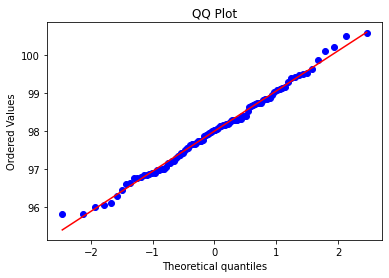

In [ ]:
normality_tests(df.my_sampleA)

In [ ]:
# T Test one sample
# Not different: p > 0.05
# Different: p < 0.05 
scs.ttest_1samp(my_sample, popmean=600)

Ttest_1sampResult(statistic=-4803.816459706255, pvalue=3.1649151709332184e-235)

In [ ]:
# T Test two dependent samples
# Not different: p > 0.05
# Different: p <= 0.05 
scs.ttest_rel(df.my_sampleA, df.my_sampleB)

Ttest_relResult(statistic=-55387.98511342691, pvalue=0.0)

# Wilcoxon

In [ ]:
df = pd.DataFrame({'my_sampleA':np.random.randint(30,300, size=100),
                   'my_sampleB': np.random.randint(34,600, size=100)})
df.head(2)

,my_sampleA,my_sampleB
0,57,61
1,238,282


In [ ]:
# Wilcoxon
# Not different: p > 0.05
# Different: p <= 0.05 
scs.wilcoxon(df.my_sampleA, df.my_sampleB)

WilcoxonResult(statistic=540.5, pvalue=8.891312516334361e-12)

In [ ]:
df.my_sampleA.median()

153.5

In [ ]:
df.my_sampleB.median()

340.0